# Домашнее задание по теме «Ансамблирование»

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет www.kaggle.com...iques/data (train.csv)
2. Построить случайный лес, вывести важность признаков
3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
4. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score

In [28]:
data = pd.read_csv('/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/Theme_11_Ansambling/train.csv')

In [29]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [30]:
# Посмотрим количество пропусков в данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [31]:
X = data.drop(['Id', 'SalePrice'], 1)
target = data['SalePrice']

# Предобработка данных

In [32]:
X['Alley'].fillna('No alley', inplace=True)

In [33]:
# Заполним пропуски в LotFrontage - атрибут показывает длину улицу, прилегающей к жилью. 
# Вероятно, что пропущенные значения говорят о том, что к дому не прилегает улица, 
# поэтому попробуем заменить пропуски на 0

In [34]:
X['LotFrontage'].fillna(0, inplace=True)

In [35]:
# Один пропуск в атрибуте Electrical
X[X['Electrical'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1379,80,RL,73.0,9735,Pave,No alley,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


In [36]:
# Заменим на наиболее часто встречаемое значение
X['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [37]:
X['Electrical'].fillna('SBrkr', inplace=True)

In [38]:
# Посмотрим на признаки MasVnrType и MasVnrArea (по 8 пропусков)

In [39]:
print(X[X['MasVnrType'].isnull()])
print(X[X['MasVnrArea'].isnull()])

      MSSubClass MSZoning  LotFrontage  LotArea Street     Alley LotShape  \
234           60       RL          0.0     7851   Pave  No alley      Reg   
529           20       RL          0.0    32668   Pave  No alley      IR1   
650           60       FV         65.0     8125   Pave  No alley      Reg   
936           20       RL         67.0    10083   Pave  No alley      Reg   
973           20       FV         95.0    11639   Pave  No alley      Reg   
977          120       FV         35.0     4274   Pave      Pave      IR1   
1243          20       RL        107.0    13891   Pave  No alley      Reg   
1278          60       RL         75.0     9473   Pave  No alley      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
234          Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
529          Lvl    AllPub   CulDSac  ...           0        0    NaN   NaN   
650          Lvl    AllPub    Inside  ...           0        0    NaN

In [40]:
# Пропуски допущены в тех же объектах - отсутствует информация по облицовке кладки и ее площади
print(X['MasVnrType'].value_counts())
print(X['MasVnrArea'].value_counts())
# Как оказалось, отсутствующих значений гораздо больше - по всей видимости облицовка в основном отсутствует,
# поэтому можно заменить пропуски на None и 0.0 соответственно

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
0.0      861
108.0      8
72.0       8
180.0      8
16.0       7
        ... 
31.0       1
366.0      1
528.0      1
894.0      1
415.0      1
Name: MasVnrArea, Length: 327, dtype: int64


In [41]:
X['MasVnrType'].fillna('None', inplace=True)
X['MasVnrArea'].fillna(0.0, inplace=True)

In [42]:
# BsmtQual BsmtCond BsmtFinType1
print(X['BsmtQual'].value_counts())
print(X['BsmtCond'].value_counts())
print(X['BsmtFinType1'].value_counts())

# В описании данных указан тип NA - фундамент отсутствует. Поскольку в значениях признаков такой тип отсутствует,
# то следует, что пропуски как раз и свидетельствуют от отстутствии фундамента. Заменим на NA.

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64


In [43]:
# В признаке BsmtExposure на пропуск больше - по всей видимости есть объект с заполненными другими данными 
# по фундаменту, но без информации по BsmtExposure
some_house = X[X['BsmtExposure'].isnull() & X['BsmtQual'].notnull() & X['BsmtCond'].notnull() & X['BsmtFinType1'].notnull()]
some_house[['BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']]

# Качество фундамента = Gd, состояние = TA, завершенность = Unf

,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1
948,NaN,Gd,TA,Unf


In [44]:
# Посмотрим на похожие дома
houses_alike = X[ (X['BsmtQual'] == 'Gd') & (X['BsmtCond'] == 'TA') & (X['BsmtFinType1'] == 'Unf')]
alike = houses_alike[['BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']]
alike['BsmtExposure'].value_counts()
# Наиболее часто встречалось значение No, можем заменить пропуск на него

No    136
Av     26
Mn     10
Gd      5
Name: BsmtExposure, dtype: int64

In [45]:
X.loc[X['BsmtExposure'].isnull() 
      & X['BsmtQual'].notnull() 
      & X['BsmtCond'].notnull() 
      & X['BsmtFinType1'].notnull(), 'BsmtExposure'] = 'No'

In [46]:
# В признаке BsmtFinType2 также на пропуск больше
some_house_1 = X[X['BsmtFinType2'].isnull() & X['BsmtQual'].notnull() & X['BsmtCond'].notnull() & X['BsmtFinType1'].notnull()]
some_house_1[['BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']]

# Качество фундамента = Gd, состояние = TA, завершенность = Unf

,BsmtFinType2,BsmtQual,BsmtCond,BsmtFinType1
332,NaN,Gd,TA,GLQ


In [47]:
# Посмотрим на похожие дома
houses_alike_1 = X[ (X['BsmtQual'] == 'Gd') & (X['BsmtCond'] == 'TA') & (X['BsmtFinType1'] == 'GLQ')]
alike_1 = houses_alike_1[['BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']]
alike_1['BsmtFinType2'].value_counts()
# Наиболее часто встречалось значение Unf, можем заменить пропуск на него

Unf    268
LwQ      4
ALQ      1
BLQ      1
Rec      1
Name: BsmtFinType2, dtype: int64

In [48]:
X.loc[X['BsmtFinType2'].isnull() 
      & X['BsmtQual'].notnull() 
      & X['BsmtCond'].notnull() 
      & X['BsmtFinType1'].notnull(), 'BsmtFinType2'] = 'Unf'

In [51]:
test_ob = X[X['BsmtExposure'].isnull() & X['BsmtQual'].isnull() & X['BsmtCond'].isnull() & X['BsmtFinType1'].isnull()]
test_ob
# Одни и те же объекты с пропусками по фундаменту

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
17,90,RL,72.0,10791,Pave,No alley,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,Shed,500,10,2006,WD,Normal
39,90,RL,65.0,6040,Pave,No alley,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand
90,20,RL,60.0,7200,Pave,No alley,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
102,90,RL,64.0,7018,Pave,No alley,Reg,Bnk,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Alloca
156,20,RL,60.0,7200,Pave,No alley,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
182,20,RL,60.0,9060,Pave,No alley,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
259,20,RM,70.0,12702,Pave,No alley,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
342,90,RL,0.0,8544,Pave,No alley,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
362,85,RL,64.0,7301,Pave,No alley,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,7,2009,ConLD,Normal
371,50,RL,80.0,17120,Pave,No alley,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


In [52]:
test_ob['BsmtFinSF1']
# Фундамент действительно отсутствует

17      0
39      0
90      0
102     0
156     0
182     0
259     0
342     0
362     0
371     0
392     0
520     0
532     0
533     0
553     0
646     0
705     0
736     0
749     0
778     0
868     0
894     0
897     0
984     0
1000    0
1011    0
1035    0
1045    0
1048    0
1049    0
1090    0
1179    0
1216    0
1218    0
1232    0
1321    0
1412    0
Name: BsmtFinSF1, dtype: int64

In [53]:
# Теперь все признаки, относящиеся к фундаменту имеют одинаковое количество пропусков - заменим их на NA
X['BsmtQual'].fillna('NA', inplace=True)
X['BsmtCond'].fillna('NA', inplace=True)
X['BsmtFinType1'].fillna('NA', inplace=True)
X['BsmtExposure'].fillna('NA', inplace=True)
X['BsmtFinType2'].fillna('NA', inplace=True)

Посмотрим на пропуски по камину (Fireplaces)

In [56]:
X['Fireplaces'].value_counts()
# В 690 домах нет камина, что соответствует пропускам в признаки по качеству камина (FireplaceQu) - заменим на NA
X['FireplaceQu'].fillna('NA', inplace=True)

Пропуски по данным о гаражах

In [57]:
# Исходя из описания данных пропуски должны означать отсутствие гаража (NA)
X['GarageType'].fillna('NA', inplace=True)
X['GarageCond'].fillna('NA', inplace=True)
X['GarageYrBlt'].fillna('NA', inplace=True)
X['GarageFinish'].fillna('NA', inplace=True)
X['GarageQual'].fillna('NA', inplace=True)

Пропуски по бассейнам

In [62]:
# Бассейны есть всего в 7 домах
houses_pools = data[data['PoolQC'].notnull() == True]
houses_pools[['PoolArea', 'PoolQC', 'SalePrice']]

,PoolArea,PoolQC,SalePrice
197,512,Ex,235000
810,648,Fa,181000
1170,576,Gd,171000
1182,555,Ex,745000
1298,480,Gd,160000
1386,519,Fa,250000
1423,738,Gd,274970


In [68]:
data_1 = data.copy()
data_1['PoolQC'].fillna('NA', inplace=True)

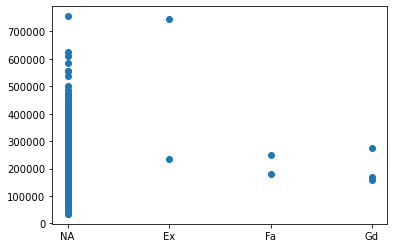

In [72]:
plt.scatter(data_1['PoolQC'], data_1['SalePrice'])
# Видно, что дома без бассейнов могут стоить как дешевле, так и дороже, чем дома с бассейнами - новых знаний 
# об объектах атрибуты, связанные с бассейнами не дают, поэтому можно убрать эти признаки

In [75]:
X.drop(['PoolQC', 'PoolArea'], 1, inplace=True)

Пропуски по Fence и MiscFeature

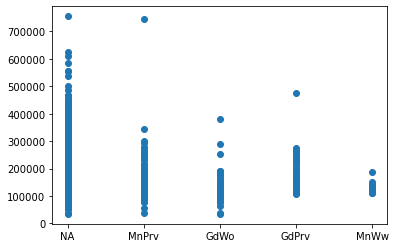

In [79]:
data_1['Fence'].fillna('NA', inplace=True)
plt.scatter(data_1['Fence'], data_1['SalePrice'])
# Зависимость есть - стоимость выше в среднем при хорошем уровне прайваси и дерева. Можно оставить признак

In [80]:
X['Fence'].fillna('NA', inplace=True)

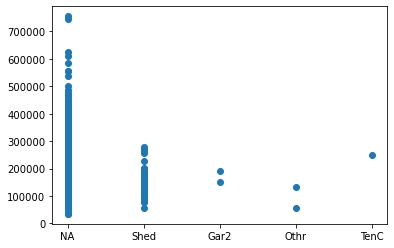

In [78]:
data_1['MiscFeature'].fillna('NA', inplace=True)
plt.scatter(data_1['MiscFeature'], data_1['SalePrice'])
# Можно убрать этот признак

In [81]:
X.drop(['MiscFeature'], 1, inplace=True)


In [112]:
X.drop(['MiscVal'], 1, inplace=True)

Теперь пропусков нет

In [120]:
X = pd.get_dummies(X)
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,1,0,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,1,0,0,0,0,1,0


# Построим случайный лес

In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [129]:
x_train, x_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

In [193]:
reg_rf = RandomForestRegressor(n_estimators=500, max_depth=8, min_samples_leaf=10, max_features=0.7, n_jobs=-1)
reg_rf.fit(x_train, y_train)  

RandomForestRegressor(max_depth=8, max_features=0.7, min_samples_leaf=10,
                      n_estimators=500, n_jobs=-1)

In [194]:
reg_rf.score(x_test, y_test)

0.863106392343975

Важность признаков

In [204]:
feature_imp = pd.Series(reg_rf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

OverallQual         0.499988
GrLivArea           0.142378
GarageCars          0.067292
ExterQual_TA        0.035386
TotalBsmtSF         0.031330
                      ...   
BsmtFinType2_BLQ    0.000000
BsmtFinType2_GLQ    0.000000
BsmtFinType2_LwQ    0.000000
BsmtFinType2_NA     0.000000
Alley_Pave          0.000000
Length: 388, dtype: float64

In [217]:
feature_imp = feature_imp[feature_imp > 0.01]
feature_imp

OverallQual     0.499988
GrLivArea       0.142378
GarageCars      0.067292
ExterQual_TA    0.035386
TotalBsmtSF     0.031330
BsmtFinSF1      0.029259
1stFlrSF        0.026432
GarageArea      0.020455
BsmtQual_Ex     0.020453
YearBuilt       0.020346
LotArea         0.014332
FullBath        0.010688
dtype: float64

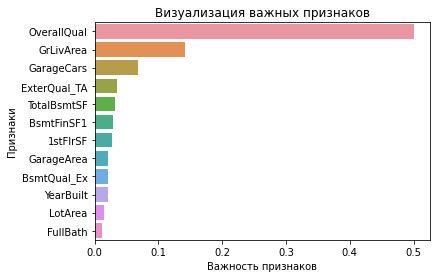

In [218]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

# Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

In [238]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [252]:
st_regressor = StackingRegressor(
    [
        ('sgd', SGDRegressor()),
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor())
    ],
    LinearRegression())

In [253]:
st_regressor.fit(x_train, y_train)

StackingRegressor(estimators=[('sgd', SGDRegressor()),
                              ('lr', LinearRegression()),
                              ('dt', DecisionTreeRegressor())],
                  final_estimator=LinearRegression())

In [254]:
st_regressor.final_estimator_

LinearRegression()

In [255]:
st_regressor.score(x_test, y_test)

0.7631646301154514

Применим станадртизацию

In [258]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = X.select_dtypes(include=numerics)

In [264]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train[list(newdf.columns)])

X_train[list(newdf.columns)] = scaler.transform(X_train[list(newdf.columns)])
X_test[list(newdf.columns)] = scaler.transform(X_test[list(newdf.columns)])

<ipython-input-264-d2d484d54674>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[list(newdf.columns)] = scaler.transform(X_train[list(newdf.columns)])
/Users/glebmutovin/Downloads/ENTER/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-264-d2d484d54674>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [267]:
st_regressor.fit(X_train, Y_train)

StackingRegressor(estimators=[('sgd', SGDRegressor()),
                              ('lr', LinearRegression()),
                              ('dt', DecisionTreeRegressor())],
                  final_estimator=LinearRegression())

In [268]:
st_regressor.score(X_test, Y_test)

0.874346071816842

При стекинге результат получился немного лучше